In [16]:
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt
from Network_models import HD_cell, GD_cell, traj, circle_period
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.signal import find_peaks, peak_widths

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:

# simulation time step
bm.set_dt(0.1)

# 环境设置
x1 = -np.pi
x2 = np.pi
x_bound = np.array([x1, x2, x2, x1, x1])
y_bound = np.array([x1, x1, x2, x2, x1])

num_hd = 100
noise_stre = 0.5
offset_len = 50/bm.pi
Animal_speed = bm.pi/100
A = 3. #1.6
mbar = 20.
alpha_0 = 0.3
theta_modulation_stre = 0.3

# forward-backward sweeps without directional input: offset_len = 0
# left-right sweeps with directional input: offset_len = 50/bm.pi
# shared parameters: , A = 3., mbar = 20, noise_stre =0.1, Animal_speed = bm.pi/100, alpha_0 = 0.3


# for cycling behavior, A = 1.6, mbar = 20, offset_len = 50/bm.pi, noise_stre =0.1, Animal_speed = bm.pi/200, alpha_0 = 0.3 or 0.7, both ok
# left-right sweeps without directional input, A = 1.6, mbar = 20, offset_len = 0, noise_stre = 0.1, alpha_0 = 0.7, Animal_speed = bm.pi/100 
# left-right sweeps with directional input, A = 1.6, mbar = 20, offset_len = 50/bm.pi, noise_stre = 0.1, alpha_0 = 0.7 or 0.3 (both ok), Animal_speed = bm.pi/100 

numT = int(4*np.pi/(bm.dt*Animal_speed))
Grid_net = GD_cell(
    A = A, # 3
    a = 0.8,
    k = 1.0,
    tau = 1.,
    tau_v = 10.,
    mbar = mbar, # 20.
    offset_len = offset_len, 
    noise_stre = noise_stre,
    num_hd = num_hd,
)
HD_net = HD_cell(num=num_hd, 
                 noise_stre=0.01, 
                 tau=1., tau_v=10., 
                 k=1., mbar=12, a=0.4, A=2., J0=4., 
                 z_min=-bm.pi, z_max=bm.pi)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Moving_speed):  # 20 x size
    manual_HD = False
    if not manual_HD:
        T_theta = 10
        #calculate TheataModulator at time step i
        t = i*bm.dt
        theta_phase = bm.mod(t, T_theta)/T_theta # theta phase（0,1）
        ThetaModulator_HD = 1+0.3*bm.cos(theta_phase*2*bm.pi)
        ThetaModulator_GC = 1+theta_modulation_stre*bm.cos(theta_phase*2*bm.pi)
        #calculate ThetaShutdown at time step i (whether to shut down the newtork activity or not)
        ThetaShutdown = 0. #bm.where(theta_phase>0.5, -1, 0)
        
        #calculate internal head direction
        HD_net.step_run(i, Head_direction, ThetaModulator_HD)
        Internal_direction = HD_net.center #center of mass of internal direction
        HD_activity = HD_net.r 
        # print(HD_activity.shape)
        
    else:
        T_theta = 20
        t = i*bm.dt
        n_cycle = t//T_theta #第几个theta cycle
        theta_phase = bm.mod(t, T_theta)/T_theta # theta phase（0,1）
        Internal_direction = 0.5* theta_phase * bm.where(bm.mod(n_cycle,2)==0, 1, -1) + bm.pi/4#偶数个theta cycle逆时针旋转，奇数顺时针
        ThetaModulator_GC = bm.exp(-theta_phase*4)*4 #1.0
        # theta_input = bm.sign(bm.sin(t*2*bm.pi/T_theta)) # Theta input is moved out from Grid cell class
        ThetaShutdown = bm.where(theta_phase>0.8, -10, 0) #artificially shut down the bump activities    
          
    #update the grid cell network 
    Grid_net.step_run(i, Animal_location, HD_activity, ThetaModulator_GC, ThetaShutdown, Moving_speed)
    
    #get results
    GC_bumpcenter = Grid_net.center
    center_grid_input = Grid_net.center_conjG
    GC_bumpactivity = Grid_net.r
    return GC_bumpcenter, Internal_direction, center_grid_input, GC_bumpactivity, HD_activity


# run network

time_steps = np.arange(numT)

x = traj(x0=-np.pi, v=Animal_speed, T=numT)
Animal_location = bm.array([x, x]).transpose()
Head_direction = bm.pi/4*bm.ones(numT) #fixed head direction, mimicking the animal running in a straight line
Moving_speed = Animal_speed*bm.ones([numT,1])
#ThetaModulator = bm.ones(numT)+0.3*bm.sin(time_steps*2*bm.pi/100)
#ThetaShutdown = bm.zeros(numT)

center_grid, center_HD, center_grid_input, r_grid, r_HD = bm.for_loop(
    run_CoupleNet, (time_steps, Animal_location, Head_direction, Moving_speed), progress_bar=True
)


  0%|          | 0/3999 [00:00<?, ?it/s]

In [18]:
start=int(numT/2)
data = circle_period(center_HD[start:].reshape(-1)-Head_direction[start:].reshape(-1))
print(data.shape)
peaks_hd, _ = find_peaks(data)
distances = np.diff(peaks_hd)
print('theta period of head-direction sweeps', distances*bm.dt/2)
print('sweep amplitude of head-direction sweeps', (np.max(data)-np.min(data))/2)
sweep_amplitude = (np.max(data)-np.min(data))/2

(2000,)
theta period of head-direction sweeps [10. 10. 10. 10. 10. 10. 10. 10. 10.]
sweep amplitude of head-direction sweeps 0.56553053855896


(2000,)
theta period of grid cell peaks [10.2 10.2  9.8 10.1  9.9  9.9 10.  10.1  9.9 10.  10.2  9.9 10.  10.
 10.  10.1  9.8 10.1  9.9]
theta period of grid cell troughs [10.  10.1 10.3  9.9  9.9 10.  10.   9.6 10.2 10.2  9.7 10.3  9.9 10.1
  9.9 10.2 10.   9.7  9.9]
sweep amplitude of grid cell sweeps 1.1872611


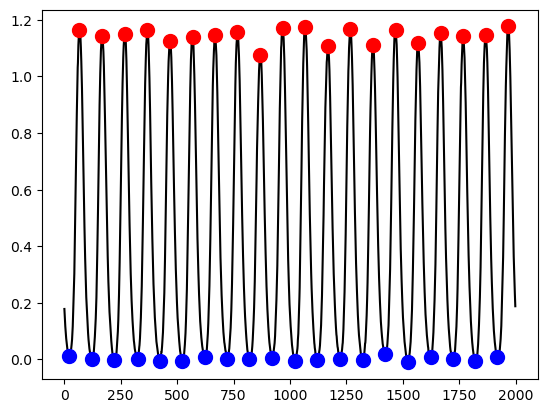

In [19]:
start=int(numT/2)
dis_x_grid = circle_period(center_grid[start:, 0].reshape(-1)-Animal_location[start:, 0].reshape(-1))
dis_y_grid = circle_period(center_grid[start:, 1].reshape(-1)-Animal_location[start:, 1].reshape(-1))
dis_vec = bm.array([dis_x_grid, dis_y_grid])
moving_vec = bm.array([bm.sqrt(2)/2, bm.sqrt(2)/2]).reshape(1,2)
projection = bm.matmul(moving_vec, dis_vec).reshape(-1,)
print(projection.shape)

data = projection
peaks_grid, _ = find_peaks(data)
troughs_grid, _ = find_peaks(-data)
# 计算每个峰的宽度
widths_pks = peak_widths(data, peaks_grid, rel_height=0.5)[0]
widths_trs = peak_widths(-data, troughs_grid, rel_height=0.5)[0]
# 筛选出具有最小宽度的峰
peaks_grid = peaks_grid[widths_pks >= 20]
troughs_grid = troughs_grid[widths_trs >= 20]
plt.plot(projection,'k')
plt.plot(peaks_grid,projection[peaks_grid],'r.',markersize=20)
plt.plot(troughs_grid,projection[troughs_grid],'b.',markersize=20)
distances_peaks = np.diff(peaks_grid)
distances_troughs = np.diff(troughs_grid)
print('theta period of grid cell peaks', distances_peaks*bm.dt)
print('theta period of grid cell troughs', distances_troughs*bm.dt)
print('sweep amplitude of grid cell sweeps', np.max(data)-np.min(data))
# sweep_amplitude = (np.max(data)-np.min(data))/2

[ 20.26245994 -18.26843173  17.92003334 -17.37062386  19.9388027
 -17.78760514  20.28182479 -20.19390401  23.8232346  -18.42705228
  18.56885178 -20.8967559   19.09818526 -22.28967214  19.16710364
 -20.03458988  18.67584383 -19.72149197  19.6983891  -19.01347253]


(-3.141592653589793, 3.141592653589793)

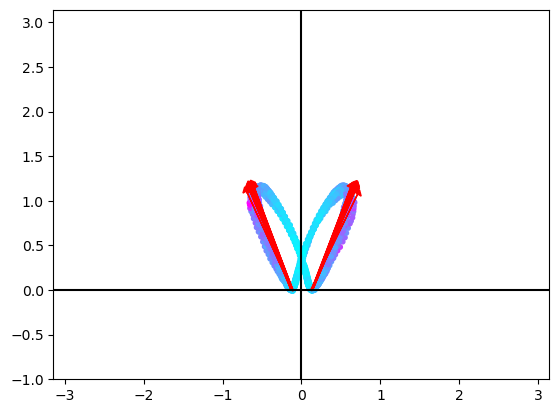

In [20]:
W_rotate = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)], [np.sin(np.pi/4), np.cos(np.pi/4)]])
Dis = np.array([dis_x_grid, dis_y_grid])
Dis_rotate = np.matmul(W_rotate, Dis)
max_r_grid = np.max(r_grid, axis=1) 
fig, ax = plt.subplots()
sc = ax.scatter(
                Dis_rotate[0,:],
                Dis_rotate[1,:],
                c=max_r_grid[start:],
                cmap="cool",
                s=10,
)
Start = Dis_rotate[:, troughs_grid]
End = Dis_rotate[:, peaks_grid]

num_cycle = troughs_grid.shape[0]
sweep_direction = np.zeros(num_cycle)
for i in range(num_cycle):
    ax.arrow(Start[0,i], Start[1,i], End[0,i], End[1,i], head_width=0.1, head_length=0.05, fc='red', ec='red')
    sweep_direction[i] = np.arctan((End[0,i]-Start[0,i])/(End[1,i]-Start[1,i]))
print(sweep_direction/np.pi*180)



# 添加 x=0 处的直线
plt.axvline(x=0, color='k')
# 添加 y=0 处的直线
plt.axhline(y=0, color='k')
ax.set_ylim(-1, np.pi)
ax.set_xlim(-np.pi, np.pi)



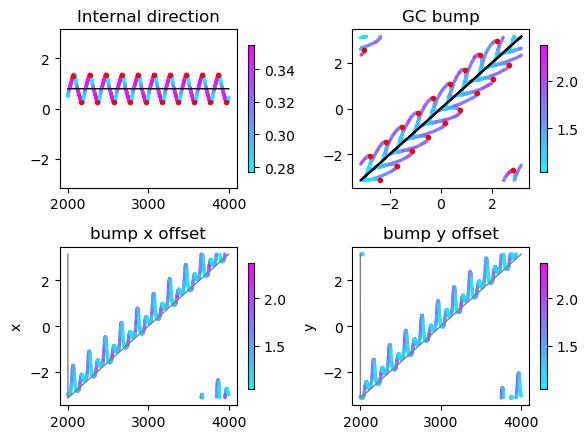

In [21]:

max_bump_activity = np.max(r_HD, axis=1)
fig, axs = plt.subplots(2, 2, figsize=(6, 4.5))
s_size = 2

ax = axs[0, 0]
ax.plot(time_steps[start:], Head_direction[start:], linewidth=1, color='black')
ax.plot(time_steps[start+peaks_grid], center_HD[start+peaks_grid],'r.')

# cb = ax.scatter(time_steps[10:], 
#                 center_HD[10:], 
#                 c=max_bump_activity[10:], 
#                 cmap='cool', s=s_size)
cb = ax.scatter(time_steps[start:], 
                center_HD[start:], 
                c=max_bump_activity[start:], 
                cmap='cool', s=s_size)
ax.set_ylim(-bm.pi, bm.pi)
#colorbar
cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
ax.set_title('Internal direction')

ax = axs[0, 1]
ax.plot(center_grid[start+peaks_grid, 0], center_grid[start+peaks_grid, 1], 'r.')
sc = ax.scatter(
                center_grid[start:, 0],
                center_grid[start:, 1],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.plot(Animal_location[start:, 0], Animal_location[start:, 1], color="black")
ax.set_title('GC bump')


ax = axs[1, 0]
# ax.scatter(range(len(center_grid[start:, 0])), x[start:], s=1, color='grey')
ax.plot(time_steps[start:], x[start:], color='grey', linewidth=1)
ax.set_ylabel("x")
sc = ax.scatter(
                time_steps[start:],
                center_grid[start:, 0],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump x offset')


ax = axs[1, 1]
# ax.scatter(range(len(center_grid[start:, 0])), x[start:], s=1, color='grey')
ax.plot(time_steps[start:], x[start:], color='grey', linewidth=1)
ax.set_ylabel("y")
sc = ax.scatter(
                time_steps[start:],
                center_grid[start:, 1],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump y offset')

plt.tight_layout()
plt.show()

### generate a figure for iNav

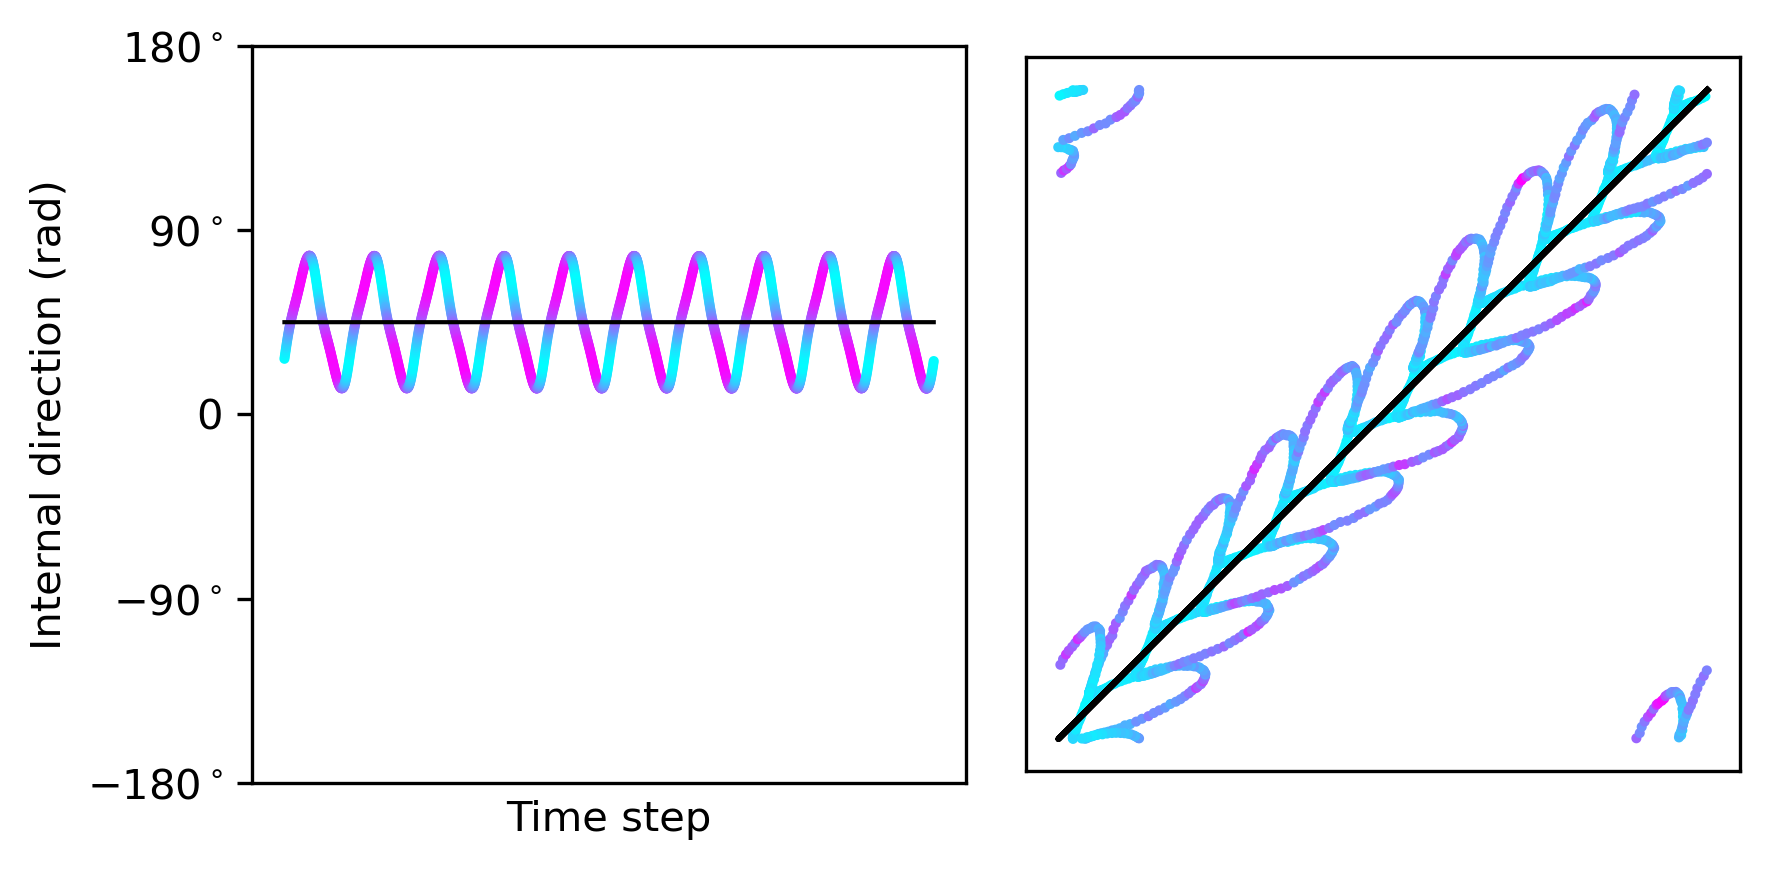

In [22]:
start=int(numT/2)
max_bump_activity = np.max(r_HD, axis=1)
fig, axs = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
s_size = 2

ax = axs[0]
ax.plot(time_steps[start:], Head_direction[start:], linewidth=1, color='black')
cb = ax.scatter(time_steps[start:], 
                center_HD[start:], 
                c=max_bump_activity[start:], 
                cmap='cool', s=s_size)
ax.set_ylim(0, np.pi/2)
ax.set_xticks([])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(['$-180^\circ$','$-90^\circ$', '0', '$90^\circ$', '$180^\circ$'])
ax.set_xlabel('Time step')
ax.set_ylabel('Internal direction (rad)')
# #colorbar
# cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
# cbar.set_label('HD activity')

ax = axs[1]
sc = ax.scatter(
                center_grid[start:, 0],
                center_grid[start:, 1],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
ax.plot(Animal_location[start:, 0], Animal_location[start:, 1], color="black")
#ticks off
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', 'box')
# cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
# #colorbar ticks ooff
# cbar.set_ticks([])
# cbar.set_label('Grid cell activity')

# for ax in axs:
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/GC_sweeps_iNav.pdf', dpi=300)

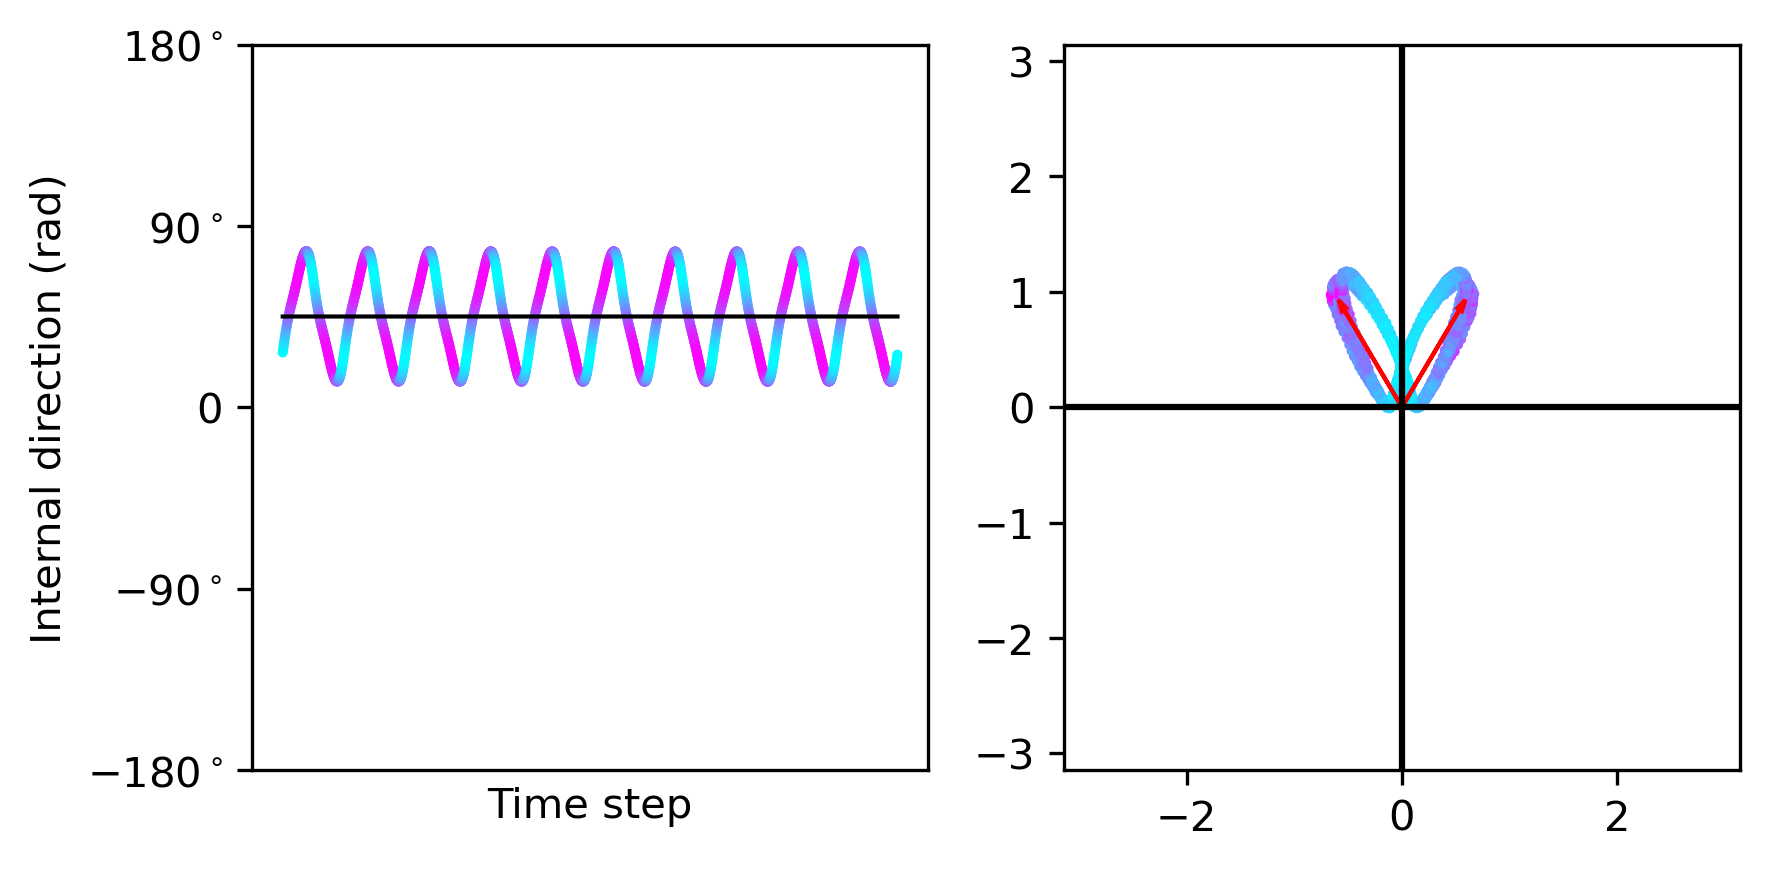

In [23]:
start=int(numT/2)
max_bump_activity = np.max(r_HD, axis=1)
fig, axs = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
s_size = 2

ax = axs[0]
ax.plot(time_steps[start:], Head_direction[start:], linewidth=1, color='black')
cb = ax.scatter(time_steps[start:], 
                center_HD[start:], 
                c=max_bump_activity[start:], 
                cmap='cool', s=s_size)
ax.set_ylim(0, np.pi/2)
ax.set_xticks([])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(['$-180^\circ$','$-90^\circ$', '0', '$90^\circ$', '$180^\circ$'])
ax.set_xlabel('Time step')
ax.set_ylabel('Internal direction (rad)')
# #colorbar
# cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
# cbar.set_label('HD activity')
dis_x = circle_period(center_grid[start:, 0]-Animal_location[start:, 0])
dis_y = circle_period(center_grid[start:, 1]-Animal_location[start:, 1])
W_rotate = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)], [np.sin(np.pi/4), np.cos(np.pi/4)]])
Dis = np.array([dis_x, dis_y])
Dis_rotate = np.matmul(W_rotate, Dis)
ax = axs[1]
sc = ax.scatter(
                Dis_rotate[0,:],
                Dis_rotate[1,:],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlim(-np.pi, np.pi)

# 计算向量的分量
length = 1
theta = sweep_amplitude
vx1 = length * np.cos(np.pi/2+theta)
vy1 = length * np.sin(np.pi/2+theta)
vx2 = length * np.cos(np.pi/2-theta)
vy2 = length * np.sin(np.pi/2-theta)
# 绘制向量 (箭头)
ax.arrow(0, 0, vx1, vy1, head_width=0.05, head_length=0.1, fc='blue', ec='red')
ax.arrow(0, 0, vx2, vy2, head_width=0.05, head_length=0.1, fc='red', ec='red')
#ticks off
# ax.set_xticks([])
# ax.set_yticks([])
# 添加 x=0 处的直线
plt.axvline(x=0, color='k')
# 添加 y=0 处的直线
plt.axhline(y=0, color='k')
# ax.set_aspect('equal', 'box')
# cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
# #colorbar ticks ooff
# cbar.set_ticks([])
# cbar.set_label('Grid cell activity')

# for ax in axs:
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/GC_sweeps_iNav.pdf', dpi=300)

### animation

In [24]:
# n_step = 10
# phi = Grid_net.value_grid
# transform = bm.array([[1, 0], [0, 1]])
# pos_mec = bm.matmul(transform, phi.T).T

# x_min, x_max = np.min(pos_mec[:, 0]), np.max(pos_mec[:, 0])
# y_min, y_max = np.min(pos_mec[:, 1]), np.max(pos_mec[:, 1])

# x_range = x_max - x_min
# y_range = y_max - y_min
# x_min -= 0.1 * x_range
# x_max += 0.1 * x_range
# y_min -= 0.1 * y_range
# y_max += 0.1 * y_range

# fig, ax_ani = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
# ax_ani.set_aspect("equal")
# ax_ani.grid(True)

# data = r_grid[start::n_step, :]
# T = data.shape[0]

# ax_ani.plot(x, x, color="black")

# vmin1 = 0
# vmax1 = np.max(data)
# scatter1 = ax_ani.scatter([], [], c=[], s=200, cmap="Blues", vmin=vmin1, vmax=vmax1)
# ax_ani.set_title("Bump activity")
# ax_ani.set_xlim(x_min, x_max)
# ax_ani.set_ylim(y_min, y_max)

# def update(frame):
#     y1 = data[frame].flatten()
#     scatter1.set_offsets(np.column_stack((pos_mec[:, 0], pos_mec[:, 1])))
#     scatter1.set_array(y1)
#     return scatter1

# ani = FuncAnimation(fig, update, frames=T, interval=100, blit=False)

# plt.tight_layout()

# aniname = "./figures/grid_activities.gif"
# ani.save(aniname, writer="Pillow", fps=10)

# # Display animation inline in Jupyter Notebook
# HTML(ani.to_jshtml())